In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.models.properties.modular_properties.base.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.models.unit_models import Flash

# Import R32, R125, IL info file
from HFCs_bmimPF6_PR_m import configuration

    has been moved to idaes.models.properties.modular_properties.phase_equil
    (deprecated in 2.0.0.alpha0) (called from <frozen
    importlib._bootstrap>:241)


In [2]:
m1 = ConcreteModel()

m1.fs = FlowsheetBlock(default={"dynamic": False})

m1.fs.properties = GenericParameterBlock(default=configuration)

m1.fs.F101 = Flash(default={"property_package": m1.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m2 = ConcreteModel()

m2.fs = FlowsheetBlock(default={"dynamic": False})

m2.fs.properties = GenericParameterBlock(default=configuration)

m2.fs.F101 = Flash(default={"property_package": m2.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m3 = ConcreteModel()

m3.fs = FlowsheetBlock(default={"dynamic": False})

m3.fs.properties = GenericParameterBlock(default=configuration)

m3.fs.F101 = Flash(default={"property_package": m3.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

In [3]:
# m1.display()

Model unknown

  Variables:
    None

  Objectives:
    None

  Constraints:
    None

  Blocks:
    Block fs
    
      Variables:
        None
    
      Objectives:
        None
    
      Constraints:
        None
    
      Blocks:
        Block fs.properties
        
          Variables:
            PR_kappa : PR binary interaction parameters
                Size=9, Index=fs.properties.PR_kappa_index
                Key                    : Lower : Value : Upper : Fixed : Stale : Domain
                      ('R125', 'R125') :  None :   0.0 :  None :  True : False :  Reals
                       ('R125', 'R32') :  None :   0.0 :  None :  True : False :  Reals
                   ('R125', 'bmimPF6') :  None :   0.0 :  None :  True : False :  Reals
                       ('R32', 'R125') :  None :   0.0 :  None :  True : False :  Reals
                        ('R32', 'R32') :  None :   0.0 :  None :  True : False :  Reals
                    ('R32', 'bmimPF6') :  None :   0.0 :  None

                        Key                    : Lower : Body                : Upper
                        ('Vap', 'Liq', 'R125') :   0.0 : -3.0415638722494185 :   0.0
                         ('Vap', 'Liq', 'R32') :   0.0 :  -2.781079486317147 :   0.0
                    log_mole_frac_phase_comp_eqn : Size=5
                        Key                : Lower : Body               : Upper
                           ('Liq', 'R125') :   0.0 : 0.6666666666666667 :   0.0
                            ('Liq', 'R32') :   0.0 : 0.6666666666666667 :   0.0
                        ('Liq', 'bmimPF6') :   0.0 : 0.6666666666666667 :   0.0
                           ('Vap', 'R125') :   0.0 : 0.6666666666666667 :   0.0
                            ('Vap', 'R32') :   0.0 : 0.6666666666666667 :   0.0
                Block fs.F101.control_volume.properties_out[0.0]
                
                  Variables:
                    flow_mol :  Total molar flowrate
                        Size=1, Index=None,

                        Key                    : Lower : Body                : Upper
                        ('Vap', 'Liq', 'R125') :   0.0 : -3.0415638722494185 :   0.0
                         ('Vap', 'Liq', 'R32') :   0.0 :  -2.781079486317147 :   0.0
                    log_mole_frac_phase_comp_eqn : Size=5
                        Key                : Lower : Body               : Upper
                           ('Liq', 'R125') :   0.0 : 0.6666666666666667 :   0.0
                            ('Liq', 'R32') :   0.0 : 0.6666666666666667 :   0.0
                        ('Liq', 'bmimPF6') :   0.0 : 0.6666666666666667 :   0.0
                           ('Vap', 'R125') :   0.0 : 0.6666666666666667 :   0.0
                            ('Vap', 'R32') :   0.0 : 0.6666666666666667 :   0.0
            Block fs.F101.split
            
              Variables:
                _flow_mol_inlet_ref : Size=1, Index=fs._time, ReferenceTo=fs.F101.control_volume.properties_out[:].component('flow_mol')


In [4]:
m1.fs.properties.PR_kappa['R32', 'R125'].fix(0.8805)
m1.fs.properties.PR_kappa['R125', 'R32'].fix(0.0288)
m1.fs.properties.PR_kappa['R32', 'bmimPF6'].fix(-0.06394)
m1.fs.properties.PR_kappa['bmimPF6', 'R32'].fix(0.32976)
m1.fs.properties.PR_kappa['bmimPF6', 'R125'].fix(1.4316)
m1.fs.properties.PR_kappa['R125', 'bmimPF6'].fix(-0.0009)


In [5]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [6]:
# Set pressures to loop over
T = [275,298,323,353,383]

# Set fraction of feed compositions of HFCs to loop over
# P = [10000,20000,30000,40000,50000,60000,70000,80000,100000]
P = [100000]
# Make outlet arrays
IL_x = np.zeros((len(T),len(P)))
IL_y = np.zeros((len(T),len(P)))
R32_x = np.zeros((len(T),len(P)))
R32_y = np.zeros((len(T),len(P)))
R125_x = np.zeros((len(T),len(P)))
R125_y = np.zeros((len(T),len(P))) 
L = np.zeros((len(T),len(P)))
V = np.zeros((len(T),len(P))) 

IL_x2 = np.zeros((len(T),len(P)))
IL_y2 = np.zeros((len(T),len(P)))
R32_x2 = np.zeros((len(T),len(P)))
R32_y2 = np.zeros((len(T),len(P)))
R125_x2 = np.zeros((len(T),len(P)))
R125_y2 = np.zeros((len(T),len(P))) 
L2 = np.zeros((len(T),len(P)))
V2 = np.zeros((len(T),len(P))) 

IL_x3 = np.zeros((len(T),len(P)))
IL_y3 = np.zeros((len(T),len(P)))
R32_x3 = np.zeros((len(T),len(P)))
R32_y3 = np.zeros((len(T),len(P)))
R125_x3 = np.zeros((len(T),len(P)))
R125_y3 = np.zeros((len(T),len(P))) 
L3 = np.zeros((len(T),len(P)))
V3 = np.zeros((len(T),len(P))) 

m1.fs.F101.inlet.flow_mol.fix(10)
m1.fs.F101.inlet.temperature.fix(371)
m1.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.216)
m1.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.003)
m1.fs.F101.inlet.mole_frac_comp[0, "bmimPF6"].fix(0.781) 
m1.fs.F101.inlet.pressure.fix(1000000)

for i in range(len(T)):
    
    m1.fs.F101.vap_outlet.temperature.fix(T[i])

    for j in range(len(P)):
        m1.fs.F101.inlet.pressure.fix(P[j])
        m1.fs.F101.vap_outlet.pressure.fix(P[j])

        m1.fs.F101.initialize(outlvl=idaeslog.CRITICAL)              
        # solve the model
        status1 = solver.solve(m1, tee = False)

        # model.display()
        
        # If solution is optimal store the concentration, and calculated temperatures in the created arrays
        if (status1.solver.status == SolverStatus.ok) and (status1.solver.termination_condition == TerminationCondition.optimal):

            IL_x[i,j] = value(m1.fs.F101.liq_outlet.mole_frac_comp[0, "bmimPF6"])
            IL_y[i,j] = value(m1.fs.F101.vap_outlet.mole_frac_comp[0, "bmimPF6"])
            R32_x[i,j] = value(m1.fs.F101.liq_outlet.mole_frac_comp[0, "R32"]) 
            R32_y[i,j] = value(m1.fs.F101.vap_outlet.mole_frac_comp[0, "R32"])
            R125_x[i,j] = value(m1.fs.F101.liq_outlet.mole_frac_comp[0, "R125"])
            R125_y[i,j] = value(m1.fs.F101.vap_outlet.mole_frac_comp[0, "R125"])
            L[i,j] = value(m1.fs.F101.liq_outlet.flow_mol[0])
            V[i,j] = value(m1.fs.F101.vap_outlet.flow_mol[0])

            #Change this to feasible
            print("Running temperature:",T[i],"and HFC feed fraction",P[j])

        else:
            print('Infeasible.')

Running temperature: 275 and HFC feed fraction 100000
Running temperature: 298 and HFC feed fraction 100000
Running temperature: 323 and HFC feed fraction 100000
Running temperature: 353 and HFC feed fraction 100000
Running temperature: 383 and HFC feed fraction 100000


In [7]:
VR32_1 = np.zeros((len(T),len(P)))
VR125_1 = np.zeros((len(T),len(P)))
LR32_1 = np.zeros((len(T),len(P)))
LR125_1 = np.zeros((len(T),len(P)))

for i in range(len(T)):
    for j in range(len(P)):
        VR32_1[i,j] = R32_y[i,j] * V[i,j]
        VR125_1[i,j] = R125_y[i,j] * V[i,j]
        LR32_1[i,j] = R32_x[i,j] * L[i,j]
        LR125_1[i,j] = R125_x[i,j] * L[i,j]

PVR32_1 = np.zeros((len(T),len(P)))
PVR125_1 = np.zeros((len(T),len(P)))
PLR32_1 = np.zeros((len(T),len(P)))
PLR125_1 = np.zeros((len(T),len(P)))

for i in range(len(T)):
    for j in range(len(P)):
        PVR32_1[i,j] = VR32_1[i,j]/2.16
        PVR125_1[i,j] = VR125_1[i,j]/0.03
        PLR32_1[i,j] = LR32_1[i,j]/2.16
        PLR125_1[i,j] = LR125_1[i,j]/0.03


In [8]:
P1 = np.zeros(len(P))

for i in range(len(P)):
    P1[i] = P[i]/1e6

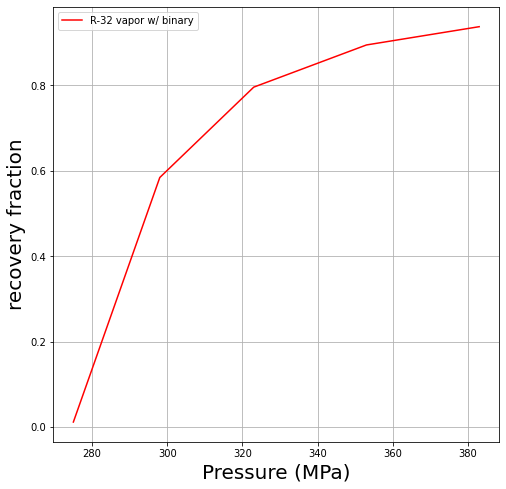

In [14]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)

# plt.plot(P1,PVR32_1[0,:],linestyle='-', color='red',label="R-32 vapor w/ binary")  
plt.plot(T,PVR32_1[:,0],linestyle='-', color='red',label="R-32 vapor w/ binary") 
# ax.set_title("recovery fraction",fontsize=20)
plt.xlabel('Pressure (MPa)',fontsize=20)
plt.ylabel('recovery fraction',fontsize=20)
plt.grid(True)
plt.legend()
plt.show()

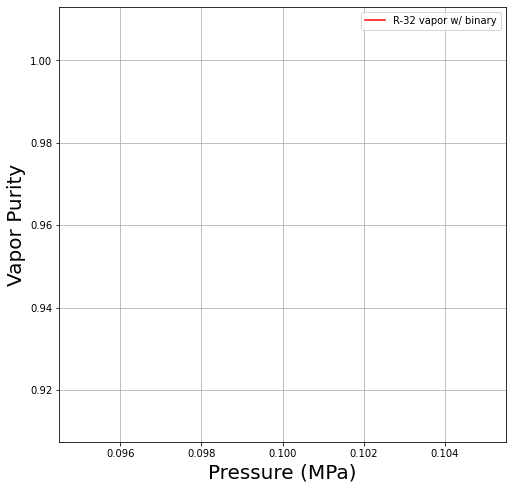

In [10]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)

plt.plot(P1,R32_y[0,:],linestyle='-', color='red',label="R-32 vapor w/ binary")  

# ax.set_title("recovery fraction",fontsize=20)
plt.xlabel('Pressure (MPa)',fontsize=20)
plt.ylabel('Vapor Purity',fontsize=20)
plt.grid(True)
plt.legend()
plt.show()

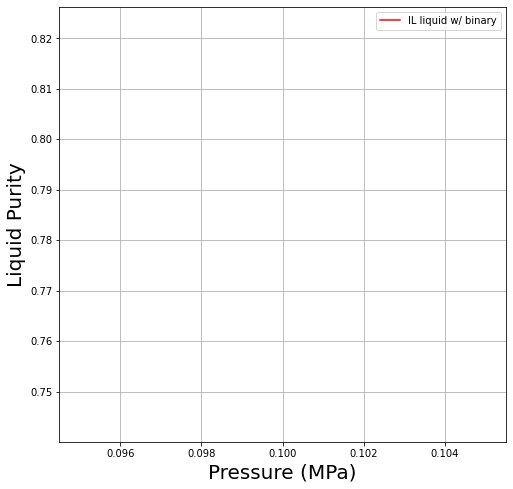

In [11]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)

plt.plot(P1,IL_x[0,:],linestyle='-', color='red',label="IL liquid w/ binary")  

# ax.set_title("recovery fraction",fontsize=20)
plt.xlabel('Pressure (MPa)',fontsize=20)
plt.ylabel('Liquid Purity',fontsize=20)
plt.grid(True)
plt.legend()
plt.show()